# To-Dos

In [1]:
## Outlier Removal
## Time zone is Data Pull
## Cumulative Logic

# Import Packages

In [3]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [5]:
check.packages(c('RPostgreSQL', 'RJDBC', 'ggplot2', 'dplyr', 'gridExtra', 'cowplot', 'rJava'))

RPostgreSQL       RJDBC     ggplot2       dplyr   gridExtra     cowplot 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      rJava 
       TRUE

In [6]:
options(scipen = 999)

# Import Data

In [163]:
## 2018-12-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0857.csv')

## 2010-01-01 -- Complete DL Outage
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0900.csv')

## 2019-01-04 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1130.csv')

## 2019-01-05 -- Chase DL Errors
df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1527.csv')

## 2019-01-06 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1125.csv')

## 2019-01-07 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1103.csv')

## 2019-01-08 -- Chase DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1117.csv')

## 2019-01-11 -- Wells Fargo DL Errors
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_0902.csv')

## 2019-01-17 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1449.csv')

## 2019-01-18 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1445.csv')

## 2019-01-19 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1443.csv')

## 2019-01-20 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1438.csv')

## 2019-01-21 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1433.csv')

## 2019-01-22 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1429.csv')

# 2019-01-23 -- Everything OK
# df = read.csv('C:/Users/jchang/Desktop/Projects/Funnel Anomaly Detection/data/dataexportdlreformat_2019-1-26_1428.csv')





df$dayofyear = as.Date(df$dayofyear)
df$grouping = as.character(df$grouping)

head(df)
str(df)

dayofyear,dayofweek,hourofday,q,bv,grouping
2018-10-05,5,0,41,30,training
2018-10-05,5,1,35,21,training
2018-10-05,5,2,27,17,training
2018-10-05,5,3,25,15,training
2018-10-05,5,4,43,31,training
2018-10-05,5,5,57,38,training


'data.frame':	2231 obs. of  6 variables:
 $ dayofyear: Date, format: "2018-10-05" "2018-10-05" ...
 $ dayofweek: int  5 5 5 5 5 5 5 5 5 5 ...
 $ hourofday: int  0 1 2 3 4 5 6 7 8 9 ...
 $ q        : int  41 35 27 25 43 57 68 107 137 186 ...
 $ bv       : int  30 21 17 15 31 38 48 84 118 112 ...
 $ grouping : chr  "training" "training" "training" "training" ...


# Clean the data

### Get Information on the "Session_Date"

In [164]:
getSessionInfo = function() {

    current.date = max(
        as.Date(df$dayofyear)
    )

    current.day = tail(
        df$dayofweek,
        1
    )

    current.hours = seq(
        from = 0,
        to = 23,
        by = 1
    )

    session.info = list(
        date = current.date,
        dow = current.day,
        hours = current.hours
    )
    
    return(session.info)
    
}

# str(getSessionInfo())
# getSessionInfo()

### Get Aggregated Data for the "Session_Date" (Test)

In [165]:
getSessionDataCumulative = function() {
    
    df.session = df[which(df$grouping == 'test'), ]

    session.point.estimates = 
        df.session %>%
        group_by(
            dayofyear
        ) %>%
#         mutate(
        transmute(
            hourofday = hourofday,
            q.session.cums = cumsum(q),
            dl.session.cums = cumsum(bv),
            ratio.session.cums = ifelse(
                cumsum(q) > 0,
                cumsum(bv)/cumsum(q),
                0
            )
        )
    
    return(session.point.estimates)
}

str(getSessionDataCumulative())
getSessionDataCumulative()

Classes 'grouped_df', 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  5 variables:
 $ dayofyear         : Date, format: "2019-01-05" "2019-01-05" ...
 $ hourofday         : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q.session.cums    : int  40 69 89 114 146 171 198 271 363 478 ...
 $ dl.session.cums   : int  33 53 63 75 88 98 115 163 225 306 ...
 $ ratio.session.cums: num  0.825 0.768 0.708 0.658 0.603 ...
 - attr(*, "vars")= chr "dayofyear"
 - attr(*, "labels")='data.frame':	1 obs. of  1 variable:
  ..$ dayofyear: Date, format: "2019-01-05"
  ..- attr(*, "vars")= chr "dayofyear"
  ..- attr(*, "drop")= logi TRUE
 - attr(*, "indices")=List of 1
  ..$ : int  0 1 2 3 4 5 6 7 8 9 ...
 - attr(*, "drop")= logi TRUE
 - attr(*, "group_sizes")= int 24
 - attr(*, "biggest_group_size")= int 24


dayofyear,hourofday,q.session.cums,dl.session.cums,ratio.session.cums
2019-01-05,0,40,33,0.8250000
2019-01-05,1,69,53,0.7681159
2019-01-05,2,89,63,0.7078652
2019-01-05,3,114,75,0.6578947
2019-01-05,4,146,88,0.6027397
2019-01-05,5,171,98,0.5730994
2019-01-05,6,198,115,0.5808081
2019-01-05,7,271,163,0.6014760
2019-01-05,8,363,225,0.6198347
2019-01-05,9,478,306,0.6401674


### Get Aggregated Data for History (Training)

In [166]:
df.hist = df[which(df$grouping == 'training'), ]
    
df.hist.mutate = 
    df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
    group_by(
        dayofyear
    ) %>%
    mutate(
        q.hist.cum = cumsum(q),
        dl.hist.cum = cumsum(bv)
    )
str(data.frame(df.hist.mutate))
head(data.frame(df.hist.mutate))
table(df.hist.mutate$hourofday)

'data.frame':	312 obs. of  8 variables:
 $ dayofyear  : Date, format: "2018-10-06" "2018-10-06" ...
 $ dayofweek  : int  6 6 6 6 6 6 6 6 6 6 ...
 $ hourofday  : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q          : int  30 18 21 14 13 20 19 52 86 104 ...
 $ bv         : int  18 11 14 9 9 8 17 38 46 73 ...
 $ grouping   : chr  "training" "training" "training" "training" ...
 $ q.hist.cum : int  30 48 69 83 96 116 135 187 273 377 ...
 $ dl.hist.cum: int  18 29 43 52 61 69 86 124 170 243 ...


dayofyear,dayofweek,hourofday,q,bv,grouping,q.hist.cum,dl.hist.cum
2018-10-06,6,0,30,18,training,30,18
2018-10-06,6,1,18,11,training,48,29
2018-10-06,6,2,21,14,training,69,43
2018-10-06,6,3,14,9,training,83,52
2018-10-06,6,4,13,9,training,96,61
2018-10-06,6,5,20,8,training,116,69



 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

In [167]:
getHistoricalDataCumulative = function() {

    df.hist = df[which(df$grouping == 'training'), ]
    
    df.hist.mutate = 
        df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
        group_by(
            dayofyear
        ) %>%
        mutate(
            q.hist.cum = cumsum(q),
            dl.hist.cum = cumsum(bv)
        )

    historical.point.estimates = 
        df.hist.mutate %>%
        group_by(
            hourofday
        ) %>%
        summarize(
            q.hist.cums = sum(q.hist.cum),
            dl.hist.cums = sum(dl.hist.cum),
            r.hist.cums = sum(dl.hist.cum)/sum(q.hist.cum),
            n.hist.cums = sum(q.hist.cum),
            sd.q.hist.cums = sd(q.hist.cum),
            sd.dl.hist.cums = sd(dl.hist.cum),
            mu.q.hist.cums = mean(q.hist.cum),
            corr.hist.cums = cor(q.hist.cum, dl.hist.cum),
            se.hist.cums = sqrt(
                (
                    (
                        sd(dl.hist.cum)^2 + 
                        sd(q.hist.cum)^2 * (sum(dl.hist.cum)/sum(q.hist.cum))^2 -
                        2 * sum(dl.hist.cum)/sum(q.hist.cum) * cor(q.hist.cum, dl.hist.cum) * sd(dl.hist.cum) * sd(q.hist.cum)
                    ) /
                    (
                        sum(q.hist.cum) *
                        mean(q.hist.cum)^2
                    )
                )
            )
        )

    return(historical.point.estimates)
}


str(getHistoricalDataCumulative())
# rbind(head(getHistoricalData(),3), tail(getHistoricalData(),3))
getHistoricalDataCumulative()

Classes 'tbl_df', 'tbl' and 'data.frame':	24 obs. of  10 variables:
 $ hourofday      : int  0 1 2 3 4 5 6 7 8 9 ...
 $ q.hist.cums    : int  489 849 1168 1437 1694 2031 2601 3517 4848 6571 ...
 $ dl.hist.cums   : int  294 499 686 836 965 1163 1488 2041 2896 4070 ...
 $ r.hist.cums    : num  0.601 0.588 0.587 0.582 0.57 ...
 $ n.hist.cums    : int  489 849 1168 1437 1694 2031 2601 3517 4848 6571 ...
 $ sd.q.hist.cums : num  9.47 14.55 18.97 22.22 24.79 ...
 $ sd.dl.hist.cums: num  5.41 8.17 10.87 13.42 15.15 ...
 $ mu.q.hist.cums : num  37.6 65.3 89.8 110.5 130.3 ...
 $ corr.hist.cums : num  0.823 0.93 0.945 0.92 0.903 ...
 $ se.hist.cums   : num  0.00399 0.00165 0.00119 0.00127 0.00122 ...


hourofday,q.hist.cums,dl.hist.cums,r.hist.cums,n.hist.cums,sd.q.hist.cums,sd.dl.hist.cums,mu.q.hist.cums,corr.hist.cums,se.hist.cums
0,489,294,0.6012270,489,9.473986,5.40892,37.61538,0.8229852,0.0039854325
1,849,499,0.5877503,849,14.550971,8.17046,65.30769,0.9304697,0.0016503812
2,1168,686,0.5873288,1168,18.968598,10.87163,89.84615,0.9450036,0.0011919135
3,1437,836,0.5817676,1437,22.224669,13.41880,110.53846,0.9195545,0.0012662721
4,1694,965,0.5696576,1694,24.787042,15.15010,130.30769,0.9025283,0.0012192967
5,2031,1163,0.5726243,2031,30.326429,17.50531,156.23077,0.9293825,0.0009308476
6,2601,1488,0.5720877,2601,41.907560,22.34806,200.07692,0.9473161,0.0007534099
7,3517,2041,0.5803241,3517,54.777756,29.70971,270.53846,0.9510900,0.0006129367
8,4848,2896,0.5973597,4848,78.181905,41.57955,372.92308,0.9795574,0.0003958367
9,6571,4070,0.6193882,6571,103.660194,60.23629,505.46154,0.9610469,0.0004345783


# Run the bootstrap

### Construct Data Frame to store final information for ggplot.

In [168]:
df.session = getSessionDataCumulative()
df.historical = getHistoricalDataCumulative()

ci.information = data.frame(
    
    hour.session = df.session$hourofday,
    r.session = df.session$ratio.session.cums,
    r.hist = df.historical$r.hist.cums,
    se.hist = df.historical$se.hist.cums,
    z_lower = rep(0,24),
    z_upper = rep(0,24),
    ci.lower = rep(0,24),
    ci.upper = rep(0,24)
)

ci.information

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.8250000,0.6012270,0.0039854325,0,0,0,0
1,0.7681159,0.5877503,0.0016503812,0,0,0,0
2,0.7078652,0.5873288,0.0011919135,0,0,0,0
3,0.6578947,0.5817676,0.0012662721,0,0,0,0
4,0.6027397,0.5696576,0.0012192967,0,0,0,0
5,0.5730994,0.5726243,0.0009308476,0,0,0,0
6,0.5808081,0.5720877,0.0007534099,0,0,0,0
7,0.6014760,0.5803241,0.0006129367,0,0,0,0
8,0.6198347,0.5973597,0.0003958367,0,0,0,0
9,0.6401674,0.6193882,0.0004345783,0,0,0,0


### Execute the Bootstrap.

In [169]:
## Set parametres and intialize.
B = 5000
bootstrap_z = vector(length = B)
alpha = 1/20

start_time = Sys.time()


## Subset the data to the DOW in question.
df.hist = df[which(df$grouping == 'training'), ]
    
df.hist.mutate = 
    df.hist[which(df.hist$dayofweek == getSessionInfo()$dow), ] %>%
    group_by(
        dayofyear
    ) %>%
    mutate(
        q.hist.cum = cumsum(q),
        dl.hist.cum = cumsum(bv)
    )

df.training.dow = df.hist.mutate


for (i in 1:24) {
    
    for (j in 1:B) {
      
      
    
        ## Subset the data to the current HOD (i).
        df.training.dow.hour = df.training.dow[which(df.training.dow$hourofday == i - 1), ]
    
        index = seq(
            1, 
            nrow(df.training.dow.hour)
        )
        resample_index = sample(
            x = index, 
            size = length(index), 
            replace = TRUE
        )
        df.training.dow.hour.resample = df.training.dow.hour[resample_index, ]
      
    
        ## Calculate statistics from the resample.
        r = sum(df.training.dow.hour.resample$dl.hist.cum)/sum(df.training.dow.hour.resample$q.hist.cum)
        n = sum(df.training.dow.hour.resample$q.hist.cum)
        sx = sd(df.training.dow.hour.resample$q.hist.cum)
        sy = sd(df.training.dow.hour.resample$dl.hist.cum)
        mx = mean(df.training.dow.hour.resample$q.hist.cum)
        corr = cor(df.training.dow.hour.resample$dl.hist.cum, df.training.dow.hour.resample$q.hist.cum)
      
        se = sqrt(
            (r^2*sx^2 + sy^2 - 2*r*corr*sx*sy)/
            (n*mx^2)
        )
      
      
        ## Calculate statistics from the training data.
        mu = ci.information$r.hist[i]
      
      
        ## Calculate the bootstrap Z
        bootstrap_z[j] = (r - mu)/se
    }
    
    
    ## For each hour, take Percentiles of the Bootstrap Z vector to caluclate the confidence interval for that hour.
    bootstrap_z = sort(bootstrap_z)
    
    ci.information$z_lower[i] = bootstrap_z[alpha/2*B]
    ci.information$z_upper[i] = bootstrap_z[(1-alpha/2)*B]
    
    ci.information$ci.lower = ci.information$r.hist - ci.information$z_upper * ci.information$se.hist
    ci.information$ci.upper = ci.information$r.hist - ci.information$z_lower * ci.information$se.hist
}

elapsed_time = Sys.time() - start_time
elapsed_time

ci.information

Time difference of 1.28954 mins

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.8250000,0.6012270,0.0039854325,-13.64366,13.83126,0.5461034,0.6556029
1,0.7681159,0.5877503,0.0016503812,-18.40604,18.82602,0.5566802,0.6181273
2,0.7078652,0.5873288,0.0011919135,-19.53433,21.53241,0.5616640,0.6106120
3,0.6578947,0.5817676,0.0012662721,-21.59952,24.74917,0.5504284,0.6091184
4,0.6027397,0.5696576,0.0012192967,-21.93382,29.76748,0.5333622,0.5964014
5,0.5730994,0.5726243,0.0009308476,-25.09829,29.55306,0.5451149,0.5959870
6,0.5808081,0.5720877,0.0007534099,-30.07079,29.32048,0.5499973,0.5947433
7,0.6014760,0.5803241,0.0006129367,-41.20859,32.08380,0.5606588,0.6055824
8,0.6198347,0.5973597,0.0003958367,-48.97568,33.56471,0.5840736,0.6167461
9,0.6401674,0.6193882,0.0004345783,-52.72551,47.55857,0.5987203,0.6423016


### Adjust morning hours of high variance (negative CI.Lower)

In [170]:
# ci.information.bounded = ci.information

# morning.start = 1
# morning.end = 11

# ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] = max(c(ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)],0.05))



# ci.information.bounded$ci.lower = ifelse(
#     ci.information.bounded$hour.session >= morning.start & ci.information.bounded$hour.session <= morning.end,
#     (
#         # y = mx + b
#         (ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.end + 1)] - ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)]) / 12 * ci.information.bounded$hour.session +
#         ci.information.bounded$ci.lower[which(ci.information.bounded$hour.session == morning.start - 1)] +

#         # jitter
#         runif(
#             n = 1,
#             min = 0,
#             max = 0.005
#         ) * (morning.end + 1 - ci.information.bounded$hour.session) * (morning.start - 1 - ci.information.bounded$hour.session)
#     ),
#     ci.information.bounded$ci.lower
# )
# ci.information.bounded

### Smooth the CI.Lower Line

In [171]:
ci.information.smooth = ci.information

smoothing.iterations = 1

for (i in 1:smoothing.iterations) {
    
    for (j in (0+1):(23-1)) {

        ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)] = mean(
            c(ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)-1], ci.information.smooth$ci.lower[which(ci.information.smooth$hour.session == j)+1])
        )
    }        
}

ci.information.smooth

hour.session,r.session,r.hist,se.hist,z_lower,z_upper,ci.lower,ci.upper
0,0.8250000,0.6012270,0.0039854325,-13.64366,13.83126,0.5461034,0.6556029
1,0.7681159,0.5877503,0.0016503812,-18.40604,18.82602,0.5538837,0.6181273
2,0.7078652,0.5873288,0.0011919135,-19.53433,21.53241,0.5521561,0.6106120
3,0.6578947,0.5817676,0.0012662721,-21.59952,24.74917,0.5427591,0.6091184
4,0.6027397,0.5696576,0.0012192967,-21.93382,29.76748,0.5439370,0.5964014
5,0.5730994,0.5726243,0.0009308476,-25.09829,29.55306,0.5469672,0.5959870
6,0.5808081,0.5720877,0.0007534099,-30.07079,29.32048,0.5538130,0.5947433
7,0.6014760,0.5803241,0.0006129367,-41.20859,32.08380,0.5689433,0.6055824
8,0.6198347,0.5973597,0.0003958367,-48.97568,33.56471,0.5838318,0.6167461
9,0.6401674,0.6193882,0.0004345783,-52.72551,47.55857,0.6029108,0.6423016


# Create the ggplot

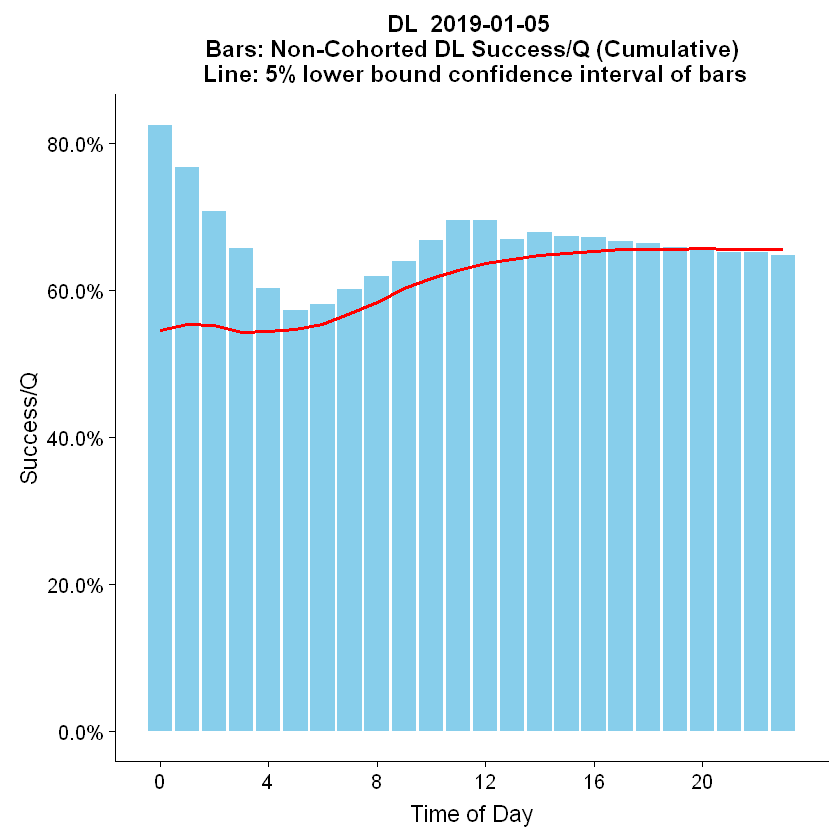

In [172]:
ggplot(
    data = ci.information.smooth,
#     data = ci.information, 
    mapping = aes(
        x = hour.session, 
        y = r.session
    )
) +
geom_col(
    fill = 'sky blue'
) + 
labs(
    x ="Time of Day", 
    y = "Success/Q", 
    title = paste(
        "DL ", getSessionInfo()$date,
        "\n", "Bars: Non-Cohorted DL Success/Q (Cumulative)", 
        "\n", "Line: 5% lower bound confidence interval of bars")
) + 
geom_line(
    aes(
        x = hour.session, 
        y = ci.lower
    ), 
    color = 'red', 
    size=1
) + 
# geom_line(
#     aes(
#         x = hour.session, 
#         y = ci.upper
#     ), 
#     color = 'blue', 
#     size=1
# ) + 
scale_y_continuous(
    labels = scales::percent 
) + 
scale_x_continuous(
    breaks = seq(0,23,4)
)# + geom_line(aes(x=hourofday, y=upper), color='springgreen4', size=1) + scale_y_continuous(labels=scales::percent) + scale_x_continuous(breaks=seq(0,23,4))
